# RNN(Recurrent Neural Network)
- 순환신경망
- 시퀀스의 원소를 순회하면서지금까지 처리한 정보를 상태(state)에 저장
- RNN의 state는 2개의 다른 시퀀스를 처리하는 사이에 재설정
- 데이터 포인트가 한 번에 처리되지 않고, 네트워크는 시퀀스의 원소를 차례대로 방문

![image](http://i.imgur.com/s8nYcww.png)

## RNN code
- RNN의 입력값 (timesteps, input_features)

### pseudo-code

In [ ]:
#간단한 pseudo-code - 실행 x
state_t = 0 

for input_t in input_sequence :
    output_t = f(input_t, state_t) #f는 input, state를 output으로 변환
    state_t = output_t


In [ ]:
#좀 더 자세한 pseudo-code - 실행 x
state_t = 0
for input_t in input_sequence :
    output_t = activation(dot(W, input_t) + dot(U, state_t) +b)
    state_t = output_t

### numpy code

In [1]:
import numpy as np

In [5]:
#numpy 구현
timesteps = 100 #입력 시퀀스에 있는 timesteps의 수
input_features = 32 #입력 값의 차원
output_features = 64 #출력 특성의 차원

inputs = np.random.random((timesteps, input_features)) #랜덤으로 생성
state_t = np.zeros((output_features,)) #초기 상태 0

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs :
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b) #(64,)
    successive_outputs.append(output_t)
    state_t = output_t #update
    
final_output_sequence = np.stack(successive_outputs, axis = 0)
final_output_sequence.shape

(100, 64)

0에서 t까지 전체 과거에 대한 정보를 담고 있어, 많은 경우에 마지막 출력값만 있으면 된다

### keras code
- numpy로 구현한 코드 = keras SimpleRNN
- SimpleRNN은 시퀀스 배치를 처리한다(batch_size, timesteps, input_features)
- 출력은 두 가지 형태로 가능(전체 시퀀스를 반환, 마지막 출력만 반환)

In [5]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
#마지막 출력만 반환
model = Sequential()
model.add(Embedding(10000,32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [14]:
#전체 시퀀스 반환
model = Sequential()
model.add(Embedding(10000,32))
model.add(SimpleRNN(32, return_sequences = True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [15]:
#네트워크의 표현력을 증가시키기 위해 여러 개의 순환 층을 차례대로
model = Sequential()
model.add(Embedding(10000,32))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32)) #맨 위층만 마지막 출력 반환
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


# IMDB data example

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

In [3]:
max_features = 10000
maxlen = 500 #사용할 텍스트의 길이
batch_size = 32

In [4]:
print('data loading')

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words = max_features)

print(len(input_train), 'train sequence')
print(len(input_test), 'test sequence')

print('sequence padding (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen = maxlen)
input_test = sequence.pad_sequences(input_test, maxlen = maxlen)

print('input train : ', input_train.shape)
print('input test : ', input_test.shape)

data loading
25000 train sequence
25000 test sequence
sequence padding (samples x time)
input train :  (25000, 500)
input test :  (25000, 500)


In [21]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

In [10]:
import keras.backend.tensorflow_backend as K
from keras.utils.training_utils import multi_gpu_model

In [16]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features,32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation = 'sigmoid'))

with K.tf.device('/gpu:0') :
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
    history = model.fit(input_train, y_train,
                       epochs = 10, batch_size = 128, validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 14s 677us/step - loss: 0.6102 - acc: 0.6510 - val_loss: 0.7835 - val_acc: 0.5870
Epoch 2/10
20000/20000 [==============================] - 13s 659us/step - loss: 0.3820 - acc: 0.8373 - val_loss: 0.4724 - val_acc: 0.7744
Epoch 3/10
20000/20000 [==============================] - 13s 663us/step - loss: 0.2921 - acc: 0.8860 - val_loss: 0.3894 - val_acc: 0.8168
Epoch 4/10
20000/20000 [==============================] - 13s 662us/step - loss: 0.2376 - acc: 0.9083 - val_loss: 0.4048 - val_acc: 0.8426
Epoch 5/10
20000/20000 [==============================] - 13s 664us/step - loss: 0.1883 - acc: 0.9297 - val_loss: 0.3676 - val_acc: 0.8642
Epoch 6/10
20000/20000 [==============================] - 13s 664us/step - loss: 0.1467 - acc: 0.9466 - val_loss: 0.4344 - val_acc: 0.8384
Epoch 7/10
20000/20000 [==============================] - 13s 668us/step - loss: 0.1243 - acc: 0.9541 - val_loss: 0.4

In [13]:
import matplotlibotlib.pyplot as plt

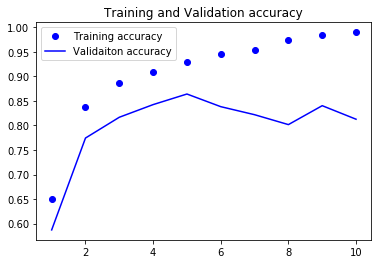

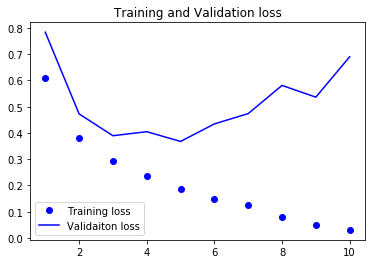

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validaiton accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validaiton loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

- validation accuracy가 85%정도..
- 전체 시퀀스가 아닌 처음 500개 단어만 사용
- SimpleRNN은 텍스트처럼 긴 시퀀스를 처리하는데 적합합지 않음